In [1]:
import time

import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

np.random.seed(42)

ModuleNotFoundError: No module named 'tensorflow'

In [91]:
class Tensor:
    def __init__(self, data, requires_grad=True):
        self.data = np.array(data, dtype=np.float64)
        self.requires_grad = requires_grad
        self.grad = None
        self._backward = lambda: None  # Função que calcula o gradiente
        self._prev = set()  # Tensores que são anteriores
        self._op = ""  # Operacao (+, -, *, /, etc)

    def __repr__(self):
        return f"Tensor(data={self.data}, requires_grad={self.requires_grad})"

    def backward(self):
        # Topologically sort
        topo_order = []
        visited = set()

        # Construindo isso no meio da função para evitar problemas de recursão
        # Ordem topologica simples
        def build_topo(tensor):
            if tensor not in visited:
                visited.add(tensor)
                for child in tensor._prev:
                    build_topo(child)
                topo_order.append(tensor)

        build_topo(self)

        # Init grad=0
        for tensor in topo_order:
            tensor.grad = np.zeros_like(tensor.data)
        # Grad do Tensor de saída é 1
        self.grad = np.ones_like(self.data)

        # Backpropagation
        for tensor in reversed(topo_order):
            tensor._backward()

    ## SOMA
    def __add__(self, other):
        other = (
            # Tem que ser um tensor
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        # Soma dos dados
        data = self.data + other.data
        # Tensor de saída
        out = Tensor(data, requires_grad=(self.requires_grad or other.requires_grad))

        
        def _backward():
            if self.requires_grad:
                grad_self = out.grad
                while grad_self.ndim > self.data.ndim:
                    
                    grad_self = grad_self.sum(axis=0)
                    
                for axis, size in enumerate(self.data.shape):
                    if size == 1:
                        grad_self = grad_self.sum(axis=axis, keepdims=True)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )
                
            if other.requires_grad:
                grad_other = out.grad
                while grad_other.ndim > other.data.ndim:
                    grad_other = grad_other.sum(axis=0)
                for axis, size in enumerate(other.data.shape):
                    if size == 1:
                        grad_other = grad_other.sum(axis=axis, keepdims=True)
                other.grad = (
                    other.grad + grad_other if other.grad is not None else grad_other
                )

        # Isso aqui é o que vai ser chamado na hora de calcular o gradiente
        out._backward = _backward
        out._prev = {self, other}
        out._op = "+"
        return out

    def __radd__(self, other):
        return self + other

    ## SUBTRAÇÃO
    def __sub__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        data = self.data - other.data
        out = Tensor(data, requires_grad=(self.requires_grad or other.requires_grad))

        def _backward():
            if self.requires_grad:
                grad_self = out.grad
                while grad_self.ndim > self.data.ndim:
                    grad_self = grad_self.sum(axis=0)
                for axis, size in enumerate(self.data.shape):
                    if size == 1:
                        grad_self = grad_self.sum(axis=axis, keepdims=True)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )
            if other.requires_grad:
                grad_other = -out.grad
                while grad_other.ndim > other.data.ndim:
                    grad_other = grad_other.sum(axis=0)
                for axis, size in enumerate(other.data.shape):
                    if size == 1:
                        grad_other = grad_other.sum(axis=axis, keepdims=True)
                other.grad = (
                    other.grad + grad_other if other.grad is not None else grad_other
                )

        out._backward = _backward
        out._prev = {self, other}
        out._op = "-"
        return out

    def __rsub__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        return other - self

    # Mult
    def __mul__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        data = self.data * other.data
        out = Tensor(data, requires_grad=(self.requires_grad or other.requires_grad))

        def _backward():
            if self.requires_grad:
                grad_self = other.data * out.grad
                while grad_self.ndim > self.data.ndim:
                    grad_self = grad_self.sum(axis=0)
                for axis, size in enumerate(self.data.shape):
                    if size == 1:
                        grad_self = grad_self.sum(axis=axis, keepdims=True)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )
            if other.requires_grad:
                grad_other = self.data * out.grad
                while grad_other.ndim > other.data.ndim:
                    grad_other = grad_other.sum(axis=0)
                for axis, size in enumerate(other.data.shape):
                    if size == 1:
                        grad_other = grad_other.sum(axis=axis, keepdims=True)
                other.grad = (
                    other.grad + grad_other if other.grad is not None else grad_other
                )

        out._backward = _backward
        out._prev = {self, other}
        out._op = "*"
        return out

    def __rmul__(self, other):
        return self * other

    # DIV
    def __truediv__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        data = self.data / other.data
        out = Tensor(data, requires_grad=(self.requires_grad or other.requires_grad))

        def _backward():
            if self.requires_grad:
                grad_self = (1 / other.data) * out.grad
                while grad_self.ndim > self.data.ndim:
                    grad_self = grad_self.sum(axis=0)
                for axis, size in enumerate(self.data.shape):
                    if size == 1:
                        grad_self = grad_self.sum(axis=axis, keepdims=True)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )
            if other.requires_grad:
                grad_other = (-self.data / (other.data**2)) * out.grad
                while grad_other.ndim > other.data.ndim:
                    grad_other = grad_other.sum(axis=0)
                for axis, size in enumerate(other.data.shape):
                    if size == 1:
                        grad_other = grad_other.sum(axis=axis, keepdims=True)
                other.grad = (
                    other.grad + grad_other if other.grad is not None else grad_other
                )

        out._backward = _backward
        out._prev = {self, other}
        out._op = "/"
        return out

    def __rtruediv__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        return other / self

    # Negação
    def __neg__(self):
        data = -self.data
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = -out.grad
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "neg"
        return out

    # Potencia
    def __pow__(self, exponent):
        data = self.data**exponent
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = exponent * (self.data ** (exponent - 1)) * out.grad
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "**"
        return out

    # Multiplic Matrizes
    def matmul(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        data = self.data @ other.data
        out = Tensor(data, requires_grad=(self.requires_grad or other.requires_grad))

        def _backward():
            if self.requires_grad:
                grad_self = out.grad @ other.data.T
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )
            if other.requires_grad:
                grad_other = self.data.T @ out.grad
                other.grad = (
                    other.grad + grad_other if other.grad is not None else grad_other
                )

        out._backward = _backward
        out._prev = {self, other}
        out._op = "matmul"
        return out

    def __matmul__(self, other):
        return self.matmul(other)

    def __rmatmul__(self, other):
        other = (
            other if isinstance(other, Tensor) else Tensor(other, requires_grad=False)
        )
        return other.matmul(self)

    # Activation functions
    def relu(self):
        data = np.maximum(0, self.data)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = out.grad.copy()
                grad_self[self.data <= 0] = 0
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "relu"
        return out

    def sigmoid(self):
        data = 1 / (1 + np.exp(-self.data))
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = data * (1 - data) * out.grad
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "sigmoid"
        return out

    def tanh(self):
        data = np.tanh(self.data)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = (1 - data**2) * out.grad
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "tanh"
        return out

    def softmax(self):
        exps = np.exp(self.data - np.max(self.data, axis=1, keepdims=True))
        data = exps / np.sum(exps, axis=1, keepdims=True)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_output = out.grad  # Shape: (batch_size, num_classes)
                s = out.data  # Softmax output, shape: (batch_size, num_classes)
                grad_input = s * (
                    grad_output - (grad_output * s).sum(axis=1, keepdims=True)
                )
                self.grad = (
                    self.grad + grad_input if self.grad is not None else grad_input
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "softmax"
        return out

    def log(self):
        data = np.log(self.data)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = (1 / self.data) * out.grad
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "log"
        return out

    def sum(self, axis=None, keepdims=False):
        data = np.sum(self.data, axis=axis, keepdims=keepdims)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = out.grad
                if axis is not None and not keepdims:
                    grad_self = np.expand_dims(grad_self, axis=axis)
                grad_self = np.broadcast_to(grad_self, self.data.shape)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "sum"
        return out

    def mean(self, axis=None, keepdims=False):
        data = np.mean(self.data, axis=axis, keepdims=keepdims)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad_self = out.grad / np.prod(self.data.shape)
                if axis is not None and not keepdims:
                    grad_self = np.expand_dims(grad_self, axis=axis)
                grad_self = np.broadcast_to(grad_self, self.data.shape)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "mean"
        return out

    def clip(self, min_value, max_value):
        data = np.clip(self.data, min_value, max_value)
        out = Tensor(data, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                grad = out.grad
                mask = (self.data >= min_value) & (self.data <= max_value)
                grad_self = grad * mask.astype(np.float64)
                self.grad = (
                    self.grad + grad_self if self.grad is not None else grad_self
                )

        out._backward = _backward
        out._prev = {self}
        out._op = "clip"
        return out


In [92]:
# Essas classes praticamente não foram alteradas vs a versão do T1
class Activation:
    @staticmethod
    def relu(z):
        return z.relu()

    @staticmethod
    def sigmoid(z):
        return z.sigmoid()

    @staticmethod
    def tanh(z):
        return z.tanh()

    @staticmethod
    def softmax(z):
        return z.softmax()


class Loss:
    @staticmethod
    def MSE(y, y_hat):
        diff = y_hat - y
        return (diff * diff).mean()

    @staticmethod
    def CrossEntropy(y, y_hat):
        epsilon = 1e-15
        y_hat_clipped = y_hat.clip(epsilon, 1 - epsilon)
        loss = -(y * y_hat_clipped.log()).sum(axis=1).mean()
        return loss


class Initialization:
    @staticmethod
    def xavier(size):
        input = size[0]
        stddev = np.sqrt(1 / input)
        return np.random.normal(0, stddev, size=size)

    @staticmethod
    def he(size):
        fan_in = size[0]
        stddev = np.sqrt(2 / fan_in)
        return np.random.normal(0, stddev, size=size)

    @staticmethod
    def normal(size):
        return np.random.randn(*size)

    @staticmethod
    def uniform(size):
        return np.random.uniform(size=size)

    @staticmethod
    def zeros(size):
        return np.zeros(size)

    @staticmethod
    def explode(size):
        return 1000000 * np.random.randn(*size)

    @staticmethod
    def vanish(size):
        return np.random.normal(size=size) / 1000000


class MLP:
    def __init__(self, neurons, activations, weight_initialization):
        self.MLP_DEPTH = len(neurons) - 1
        self.neurons = neurons
        if len(activations) == 1:
            self.activations = [activations[0] for _ in range(self.MLP_DEPTH)]
        elif len(activations) == 2 and self.MLP_DEPTH > 2:
            self.activations = [activations[0] for _ in range(self.MLP_DEPTH)]
            self.activations[-1] = activations[1]
        else:
            self.activations = activations

        if isinstance(weight_initialization, list):
            self.weights = [
                Tensor(w, requires_grad=True) for w in weight_initialization
            ]
        else:
            self.weights = [
                Tensor(
                    weight_initialization((neurons[i], neurons[i + 1])),
                    requires_grad=True,
                )
                for i in range(self.MLP_DEPTH)
            ]

        self.biases = [
            Tensor(np.zeros((1, neurons[i + 1])), requires_grad=True)
            for i in range(self.MLP_DEPTH)
        ]

    def forward(self, input):
        a = Tensor(input, requires_grad=False)  # Input shape: (batch_size, input_size)
        for i in range(self.MLP_DEPTH):
            W = self.weights[i]  # Shape: (input_size, output_size)
            b = self.biases[i]  # Shape: (1, output_size)
            z = a.matmul(W) + b  # (batch_size, output_size)
            a = self.activations[i](z)
        return a


class Optimizer:
    def __init__(self, learning_rate, parameters):
        self.learning_rate = learning_rate
        self.parameters = parameters 

    def zero_grad(self):
        for param in self.parameters:
            param.grad = None


class SGD(Optimizer):
    def __init__(self, learning_rate, parameters):
        super().__init__(learning_rate, parameters)

    def step(self):
        for param in self.parameters:
            if param.grad is not None:
                param.data -= self.learning_rate * param.grad
        self.zero_grad()


class Adam(Optimizer):
    def __init__(self, learning_rate, parameters, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate, parameters)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p.data) for p in self.parameters]
        self.v = [np.zeros_like(p.data) for p in self.parameters]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.parameters):
            grad = param.grad
            if grad is None:
                continue  
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad**2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            param.data -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        self.zero_grad()

In [93]:
# Basicamente a mesma classe do T1, add uma função pra pegar o input size
class Dataset:
    def __init__(
        self,
        train_set,
        train_labels,
        test_set,
        test_labels,
        val_split=0.15,
        num_classes=3,
    ):
        self.train_set = train_set
        self.test_set = test_set
        self.num_classes = num_classes

        # One-hot encode the labels
        self.train_labels = self.one_hot_encode(train_labels)
        self.test_labels = self.one_hot_encode(test_labels)

        # Create validation set
        val_size = int(len(train_set) * val_split)
        self.val_set = train_set[-val_size:]
        self.val_labels = self.train_labels[-val_size:]
        self.train_set = train_set[:-val_size]
        self.train_labels = self.train_labels[:-val_size]

    def one_hot_encode(self, labels):
        # Ensure labels is a 1D array
        labels = np.array(labels).ravel()
        # Check if labels are in the correct range
        if np.min(labels) < 0 or np.max(labels) >= self.num_classes:
            raise ValueError(f"Labels must be in the range 0 to {self.num_classes-1}")
        # Create one-hot encoded array
        one_hot = np.zeros((labels.size, self.num_classes))
        one_hot[np.arange(labels.size), labels] = 1
        return one_hot

    def create_batches(self, batch_size, dataset="train"):
        if dataset == "train":
            data, labels = self.train_set, self.train_labels
        elif dataset == "val":
            data, labels = self.val_set, self.val_labels
        elif dataset == "test":
            data, labels = self.test_set, self.test_labels
        else:
            raise ValueError("dataset must be 'train', 'val', or 'test'")

        indices = np.arange(len(data))
        np.random.shuffle(indices)
        for start_idx in range(0, len(data), batch_size):
            batch_indices = indices[start_idx : start_idx + batch_size]
            yield data[batch_indices], labels[batch_indices]

    def get_train_data(self):
        yield next(iter(self.create_batches(len(self.train_set), "train")))
    
    def get_test_data(self):
        return self.test_set, self.test_labels

    def get_val_data(self):
        return self.val_set, self.val_labels


In [94]:
def train(model, dataset, epochs, optimizer, loss_fn, batch_size=32):
    metrics = {}
    metrics["train_loss"] = []
    metrics["val_loss"] = []
    metrics["val_acc"] = []
    metrics["train_time"] = []

    for epoch in tqdm(range(epochs)):
        batch_loss = 0
        batch_count = 0
        start = time.time()
        
        for X_batch, y_batch in dataset.create_batches(batch_size, "train"):
            

            y_batch_tensor = Tensor(y_batch, requires_grad=False)

            pred = model.forward(X_batch)
            loss = loss_fn(y_batch_tensor, pred)
            batch_loss += loss.data
            batch_count += 1

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Zero gradients
            optimizer.zero_grad()

        metrics["train_time"].append(time.time() - start)
        
        avg_batch_loss = float(batch_loss / batch_count)
        val_acc, val_loss = test_whole_set(model, *dataset.get_val_data(), loss_fn)
        
        # Metrics
        metrics["val_loss"].append(float(val_loss.data))
        metrics["val_acc"].append(float(val_acc))       
        metrics["train_loss"].append(avg_batch_loss)

        print(
            f"Epoch {epoch + 1} Train Loss: {metrics['train_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.data:.4f}"
        )

    return metrics


def test_whole_set(model, test_data, test_labels, loss_fn):
    # test_data and test_labels are numpy arrays
    y_tensor = Tensor(test_labels, requires_grad=False)
    y_hat = model.forward(test_data)
    loss = loss_fn(y_tensor, y_hat)

    predictions = np.argmax(y_hat.data, axis=1)
    true_labels = np.argmax(test_labels, axis=1)
    accuracy = np.mean(predictions == true_labels)

    return accuracy, loss

In [95]:
# Rodando o MNIST
print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = tqdm(mnist.load_data())
print("Loaded MNIST dataset...")

# Normalizando
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0  # Flatten images
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0    # Flatten images

MNIST_num_classes = 10
MNIST = Dataset(X_train, y_train, X_test, y_test, num_classes=MNIST_num_classes)

Loading MNIST dataset...


100%|██████████| 2/2 [00:00<00:00, 60787.01it/s]

Loaded MNIST dataset...


In [96]:
# Load and preprocess the Iris dataset
iris = load_iris()
X = iris.data  # Shape: (150, 4)
y = iris.target  # Shape: (150,)

# Normalize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

IRIS = Dataset(X_train, y_train, X_test, y_test, num_classes=3)

In [97]:
DATASET = MNIST

# Treinando o modelo
EPOCHS = 20
BATCH_SIZE = 32
loss_fn = Loss.CrossEntropy
input_size = next(iter(DATASET.get_train_data()))[0].shape[1]
output_size = DATASET.num_classes
MODEL = MLP([input_size, 256, 128, output_size], [Activation.relu, Activation.softmax], Initialization.he)

parameters = MODEL.weights + MODEL.biases
optim = Adam(3e-4, parameters)
training_metrics = train(MODEL, DATASET, EPOCHS, optim, loss_fn, BATCH_SIZE)

# Testando o modelo
test_acc, test_loss = test_whole_set(MODEL, *DATASET.get_test_data(), loss_fn)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss.data:.4f}")

  5%|▌         | 1/20 [00:03<01:00,  3.17s/it]

Epoch 1 Train Loss: 0.3131, Val Acc: 0.9613, Val Loss: 0.1349


 10%|█         | 2/20 [00:06<00:59,  3.30s/it]

Epoch 2 Train Loss: 0.1236, Val Acc: 0.9714, Val Loss: 0.0987


 15%|█▌        | 3/20 [00:10<00:57,  3.38s/it]

Epoch 3 Train Loss: 0.0846, Val Acc: 0.9747, Val Loss: 0.0870


 20%|██        | 4/20 [00:13<00:54,  3.43s/it]

Epoch 4 Train Loss: 0.0613, Val Acc: 0.9778, Val Loss: 0.0778


 25%|██▌       | 5/20 [00:16<00:51,  3.42s/it]

Epoch 5 Train Loss: 0.0460, Val Acc: 0.9769, Val Loss: 0.0784


 30%|███       | 6/20 [00:20<00:47,  3.41s/it]

Epoch 6 Train Loss: 0.0341, Val Acc: 0.9789, Val Loss: 0.0736


 35%|███▌      | 7/20 [00:23<00:43,  3.38s/it]

Epoch 7 Train Loss: 0.0268, Val Acc: 0.9773, Val Loss: 0.0759


 40%|████      | 8/20 [00:28<00:47,  3.99s/it]

Epoch 8 Train Loss: 0.0214, Val Acc: 0.9774, Val Loss: 0.0803


 45%|████▌     | 9/20 [00:33<00:46,  4.27s/it]

Epoch 9 Train Loss: 0.0162, Val Acc: 0.9750, Val Loss: 0.0922


 50%|█████     | 10/20 [00:38<00:43,  4.31s/it]

Epoch 10 Train Loss: 0.0133, Val Acc: 0.9790, Val Loss: 0.0833


 55%|█████▌    | 11/20 [00:42<00:38,  4.29s/it]

Epoch 11 Train Loss: 0.0105, Val Acc: 0.9798, Val Loss: 0.0800


 60%|██████    | 12/20 [00:46<00:33,  4.23s/it]

Epoch 12 Train Loss: 0.0078, Val Acc: 0.9816, Val Loss: 0.0734


 65%|██████▌   | 13/20 [00:50<00:28,  4.07s/it]

Epoch 13 Train Loss: 0.0071, Val Acc: 0.9773, Val Loss: 0.1001


 70%|███████   | 14/20 [00:53<00:23,  3.91s/it]

Epoch 14 Train Loss: 0.0074, Val Acc: 0.9816, Val Loss: 0.0794


 75%|███████▌  | 15/20 [00:57<00:19,  3.80s/it]

Epoch 15 Train Loss: 0.0059, Val Acc: 0.9816, Val Loss: 0.0804


 80%|████████  | 16/20 [01:00<00:14,  3.63s/it]

Epoch 16 Train Loss: 0.0057, Val Acc: 0.9794, Val Loss: 0.0937


 85%|████████▌ | 17/20 [01:03<00:10,  3.36s/it]

Epoch 17 Train Loss: 0.0051, Val Acc: 0.9768, Val Loss: 0.1080


 90%|█████████ | 18/20 [01:05<00:06,  3.11s/it]

Epoch 18 Train Loss: 0.0046, Val Acc: 0.9807, Val Loss: 0.0907


 95%|█████████▌| 19/20 [01:08<00:03,  3.06s/it]

Epoch 19 Train Loss: 0.0024, Val Acc: 0.9777, Val Loss: 0.1228


100%|██████████| 20/20 [01:11<00:00,  3.57s/it]

Epoch 20 Train Loss: 0.0060, Val Acc: 0.9827, Val Loss: 0.0898
Test Accuracy: 0.9792, Test Loss: 0.0970


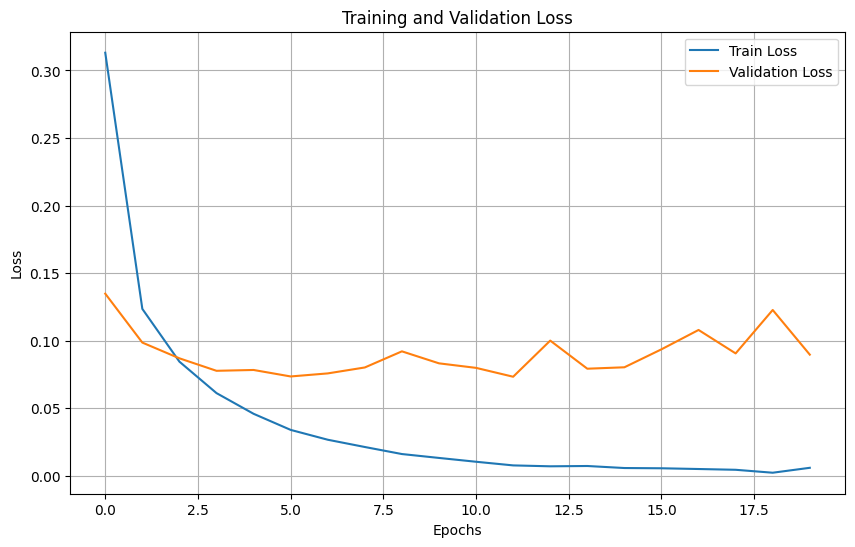

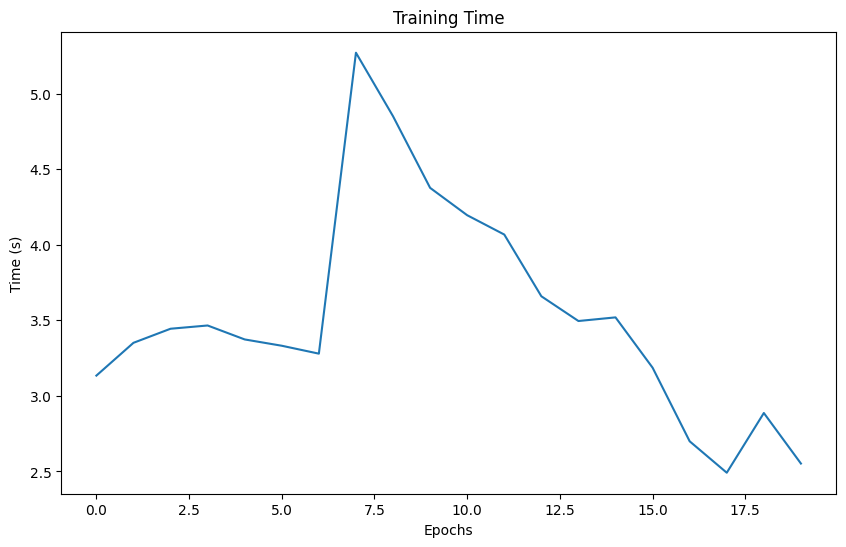

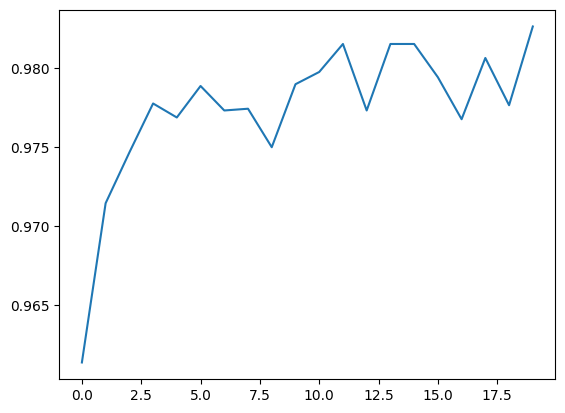

In [98]:
def plot_metrics(metrics):
    epochs = range(len(metrics["train_loss"]))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(training_metrics)

# plot time
plt.figure(figsize=(10, 6))
plt.title("Training Time")
plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.plot(range(EPOCHS), training_metrics["train_time"])
plt.show()

plt.plot(training_metrics['val_acc'])
plt.show()

In [99]:
# Define a simple function f(x) = x * 3 + x^2
def simple_function(x):
    # f(x) = 3x + x^2 == 3*2 + 2^2 = 6 + 4 = 10
    return x * 3 + x**2 

# Create a Tensor with requires_grad=True
x = Tensor(2.0, requires_grad=True)  # Let's use x = 2.0 as an example

# Compute the function output
y = simple_function(x)
print(x)
print(y)

# Perform backpropagation to compute the gradient
y.backward()

# 2*2 + 3 = 4 + 3 = 7
# Output the gradient
print(f"Value of f(x): {y.data}")
print(f"Gradient of f(x) w.r.t x: {x.grad}")
print(y._prev)
print(y._op)

Tensor(data=2.0, requires_grad=True)
Tensor(data=10.0, requires_grad=True)
Value of f(x): 10.0
Gradient of f(x) w.r.t x: 7.0
{Tensor(data=4.0, requires_grad=True), Tensor(data=6.0, requires_grad=True)}
+


In [100]:
z = y * 37 + 2

z.backward()
print(z)
print(x.grad)

Tensor(data=372.0, requires_grad=True)
259.0


In [101]:
A = Tensor([[1.0, 2.0]], requires_grad=True)  
B = Tensor([[3.0], [4.0]], requires_grad=True)

C = A @ B  

C.backward()
print(f"{A.data=}")
print(f"{B.data=}")
print(f"{C.data=}")
print(f"{A.grad=}")
print(f"{B.grad=}")
print(f"{C.grad=}")

A.data=array([[1., 2.]])
B.data=array([[3.],
       [4.]])
C.data=array([[11.]])
A.grad=array([[3., 4.]])
B.grad=array([[1.],
       [2.]])
C.grad=array([[1.]])


In [102]:
def func(x,y):
    return x@y

z = func(A,B)

z.backward()
print(A.grad)
print(B.grad)

[[3. 4.]]
[[1.]
 [2.]]
